In [12]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import copy
import pandas as pd

import matplotlib.pyplot as plt

from torch import optim
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys


from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score

In [2]:
data_folder = 'raw_data/'
data_source = '1 Supplemental Excel data.xlsx'
data_source_non = "Non-PBT.xlsx"
robcmr = 'Excluded in robustness check 2 - CMR'
robpbt = 'Excluded in robustness check 2 - PBT/vPvB'
fp_cols = ['SMILES']

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chems_data  = pd.read_excel(data_folder+data_source, sheet_name = 1, header=1)
non_pbt = pd.read_excel(data_folder+data_source_non)
non_pbt = non_pbt['SMILES']
non_pbt = pd.concat([non_pbt, pd.DataFrame(np.zeros([481]), columns=["PBT/vPvB"])], axis=1)

In [4]:
chems_ext = chems_data[fp_cols+['CMR']].loc[chems_data[robcmr] == 0]
chems_maccs = chems_data[fp_cols+['PBT/vPvB']].loc[chems_data[robpbt] == 0]
chems_maccs_non = pd.concat([chems_maccs, non_pbt], axis=0)

# chems_data['CM'] = np.where((chems_data['C'] == 1) | (chems_data['M'] == 1), 1, 0)
# chems_cm = chems_data[fp_cols+['CM']].loc[chems_data[robcmr] == 0]
# chems_r = chems_data[fp_cols+['R']].loc[chems_data[robcmr] == 0]

In [9]:
#remove not parseable molecules
if chems_maccs_non.shape[0] == 975:
    chems_maccs_non = chems_maccs_non.drop(chems_maccs_non.index[506])
    chems_maccs_non = chems_maccs_non.drop(chems_maccs_non.index[751])
    chems_maccs_non = chems_maccs_non.drop(chems_maccs_non.index[794])

In [5]:
class NeuralNet1(nn.Module):
    def __init__(self, inp_size, hid1, hid2, hid3):
        super().__init__()
        self.fc1 = nn.Linear(inp_size, hid1)
        self.fc2 = nn.Linear(hid1, hid2)
        self.fc3 = nn.Linear(hid2, hid3)
        self.fc4 = nn.Linear(hid3, 1)
        self.dropout = nn.Dropout(p=0.5)
  
    def forward(self, x):
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        x = self.dropout(torch.relu(self.fc3(x)))
        x = torch.sigmoid(self.fc4(x))
        return x

In [6]:
def trainer(input_size, H1, H2, H3, lr, X_training, y_training, X_valid, y_valid, epochs, batch_size):
    modelNN = NeuralNet1(input_size, H1, H2, H3)
    #weight_decay= 1e-6, momentum = 0.9, nesterov = True
    optimizer = optim.SGD(modelNN.parameters(), lr=lr)
    loss_function = nn.BCELoss()
    tl, vl = [], []
    lowest_loss = 1000
    for epoch in range(epochs):
        train_loss, valid_loss = [], []
        ## training part 
        modelNN.train()
        batches = int(np.floor(len(X_training)/batch_size))

        for i in range(batches):
            
            optimizer.zero_grad()
            ## 1. forward propagation
            start = i*batch_size
            end = (i+1)*batch_size

            output = modelNN(X_training[start:end])

            ## 2. loss calculation
            loss = loss_function(output.view(-1,1), y_training[start:end].view(-1,1))

            ## 3. backward propagation
            loss.backward()

            ## 4. weight optimization
            optimizer.step()

            train_loss.append(loss.item())

        ## evaluation part 
        modelNN.eval()
        loss = loss_function(modelNN(X_valid), y_valid)
        valid_loss.append(loss.item())
        if epoch % 10 == 0:
            print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Validation Loss: ", np.mean(valid_loss))
        tl.append(np.mean(train_loss))
        vl.append(np.mean(valid_loss))
    plt.plot(tl)
    plt.plot(vl)
    plt.show()
    print('epoch min valid', vl.index(min(vl)))
    return modelNN

In [7]:
def trainer2(input_size, H1, H2, H3, lr, X_training, y_training, epochs, batch_size):
    modelNN = NeuralNet1(input_size,H1, H2, H3)
    #weight_decay= 1e-6, momentum = 0.9, nesterov = True
    optimizer = optim.SGD(modelNN.parameters(), lr=lr)
    loss_function = nn.BCELoss()
    tl, vl = [], []
    for epoch in range(epochs):
        train_loss, valid_loss = [], []
        ## training part 
        modelNN.train()
        batches = int(np.floor(len(X_training)/batch_size))

        for i in range(batches):
            
            optimizer.zero_grad()
            ## 1. forward propagation
            start = i*batch_size
            end = (i+1)*batch_size

            output = modelNN(X_training[start:end])

            ## 2. loss calculation
            loss = loss_function(output.view(-1,1), y_training[start:end].view(-1,1))

            ## 3. backward propagation
            loss.backward()

            ## 4. weight optimization
            optimizer.step()

            train_loss.append(loss.item())

    return modelNN

In [8]:
def score_model(X_test, model_in, y_test):
    model_in.eval()
    output = model_in(X_test)
    output = [1 if x[0] >= 0.50 else 0 for x in output.tolist()]
    tn, fp, fn, tp = confusion_matrix(y_test.tolist(), output).ravel()
    print("tn=", tn, "fp=", fp, "fn=", fn, "tp=", tp)
    print(balanced_accuracy_score(y_test.tolist(), output))
    return balanced_accuracy_score(y_test.tolist(), output), accuracy_score(y_test.tolist(), output)

In [14]:
def maccs_som(dataset, soms_smarts):
    ml_data = []
    for mol_idx in range(dataset.shape[0]):

        mcule = Chem.MolFromSmiles(dataset['SMILES'].iloc[mol_idx])

        FPs = MACCSkeys.GenMACCSKeys(mcule).ToBitString()
#         FPs = AllChem.GetMorganFingerprintAsBitVect(x,4,useFeatures=True,nBits=1024).ToBitString()
#         FPs = AllChem.GetMorganFingerprintAsBitVect(x,4,nBits=1024).ToBitString()
        
        mol_feats = np.zeros([len(FPs)+len(soms_smarts),1])

        for i in range(len(FPs)):
            if int(FPs[i]) == 1:
                mol_feats[i] += 1
                        
        for i in range(71):
            cyp_idx_feats = mcule.GetSubstructMatches(Chem.MolFromSmarts(cyp_metabol_feats['SMARTS'].iloc[i]))
            for c in cyp_idx_feats:
                mol_feats[i+166] += 1
        ml_data.append([dataset['SMILES'].iloc[mol_idx], dataset['PBT/vPvB'].iloc[mol_idx], mol_feats.ravel()])
    return ml_data


In [15]:
cyp_metabol_feats = pd.read_excel(data_folder + "output.xls")
dat = maccs_som(chems_maccs_non, cyp_metabol_feats)
dat = pd.DataFrame(dat)

In [28]:
#CMR
# learning_rate, epochs, inp, hid, dataset, label_str = 5E-5, 35, 1024, 512, chems_ext, 'CMR'
# learning_rate, epochs, inp, hid, dataset, label_str = 5E-5, 35, 1024, 512, total, 'CMR'
# C
# learning_rate, epochs, inp, hid, dataset, label_str = 1E-4, 12, 1024, 512, chems_extC, 'C'
#M
# learning_rate, epochs, inp, hid, dataset, label_str = 3E-4, 10, 1024, 512, chems_extM, 'M'
#R
# learning_rate, epochs, inp, hid, dataset, label_str = 1E-4, 18, 1024, 512, chems_extR, 'R'

#PBT/vPvB
learning_rate, epochs, inp, hid1, hid2, hid3, dataset, label_str = 1E-3, 18, 238, 200, 100, 100, chems_maccs, 'PBT/vPvB'
# learning_rate, epochs, inp, hid, dataset, label_str = 5E-4, 18, 166, 83, total, 'PBT/vPvB'

#ED
# learning_rate, epochs, inp, hid, dataset, label_str = 5E-4, 16, 1024, 512, chems_fcfp, 'ED'

/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5082010190034735 Validation Loss:  0.4079461395740509
Epoch: 10 Training Loss:  0.272067180879671 Validation Loss:  0.3472374975681305
Epoch: 20 Training Loss:  0.19810669829362426 Validation Loss:  0.34557750821113586
Epoch: 30 Training Loss:  0.14080185301417228 Validation Loss:  0.38000309467315674
Epoch: 40 Training Loss:  0.10002802714167705 Validation Loss:  0.4548761546611786


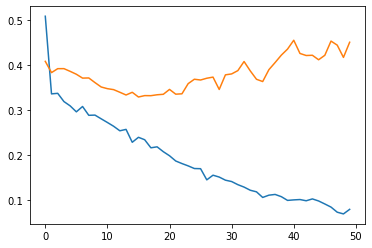

epoch min valid 15
tn= 214 fp= 1 fn= 18 tp= 10
0.6762458471760797
Epoch: 0 Training Loss:  0.503705198703141 Validation Loss:  0.39106354117393494
Epoch: 10 Training Loss:  0.2500135117499479 Validation Loss:  0.3910946547985077
Epoch: 20 Training Loss:  0.1668697896851066 Validation Loss:  0.4998621344566345
Epoch: 30 Training Loss:  0.10148567451162997 Validation Loss:  0.6876441240310669
Epoch: 40 Training Loss:  0.08510495434859656 Validation Loss:  0.5667873024940491


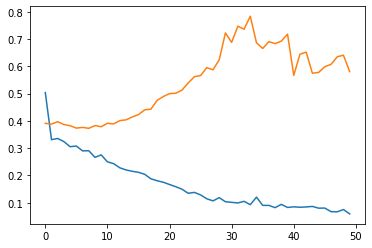

epoch min valid 7
tn= 215 fp= 0 fn= 22 tp= 6
0.6071428571428571
Epoch: 0 Training Loss:  0.5066196586551337 Validation Loss:  0.39459800720214844
Epoch: 10 Training Loss:  0.26495104132798214 Validation Loss:  0.30438879132270813
Epoch: 20 Training Loss:  0.19415615992941734 Validation Loss:  0.2959950268268585
Epoch: 30 Training Loss:  0.12390216660930711 Validation Loss:  0.2702326476573944
Epoch: 40 Training Loss:  0.09767695607572713 Validation Loss:  0.24868690967559814


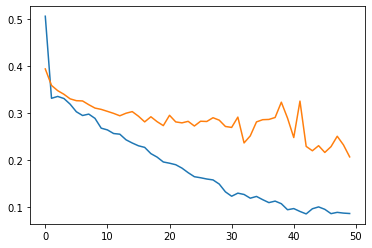

epoch min valid 49
tn= 214 fp= 1 fn= 13 tp= 15
0.765531561461794


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.49273245735415094 Validation Loss:  0.3769943118095398
Epoch: 10 Training Loss:  0.2728481201904601 Validation Loss:  0.31282100081443787
Epoch: 20 Training Loss:  0.20543624140675468 Validation Loss:  0.3013615310192108
Epoch: 30 Training Loss:  0.14374567691735013 Validation Loss:  0.3102562427520752
Epoch: 40 Training Loss:  0.11119101880067947 Validation Loss:  0.2980074882507324


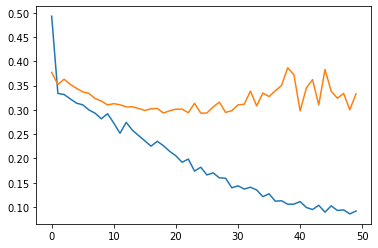

epoch min valid 24
tn= 214 fp= 0 fn= 16 tp= 12
0.7142857142857143


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5168196862113887 Validation Loss:  0.3911922574043274
Epoch: 10 Training Loss:  0.25281397587908755 Validation Loss:  0.3721795082092285
Epoch: 20 Training Loss:  0.17408661204249726 Validation Loss:  0.41324833035469055
Epoch: 30 Training Loss:  0.10947971524392729 Validation Loss:  0.4726564884185791
Epoch: 40 Training Loss:  0.09436054460079034 Validation Loss:  0.46396946907043457


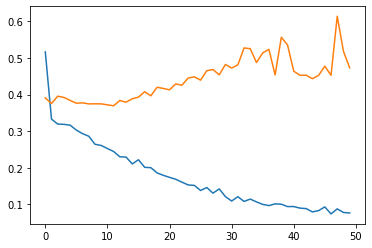

epoch min valid 11
tn= 215 fp= 0 fn= 22 tp= 6
0.6071428571428571
Epoch: 0 Training Loss:  0.5493300013501069 Validation Loss:  0.4262511432170868
Epoch: 10 Training Loss:  0.28225257826390965 Validation Loss:  0.30983585119247437
Epoch: 20 Training Loss:  0.18042017689400255 Validation Loss:  0.35153841972351074
Epoch: 30 Training Loss:  0.13223209923635296 Validation Loss:  0.3924538791179657
Epoch: 40 Training Loss:  0.09524113149894627 Validation Loss:  0.35121241211891174


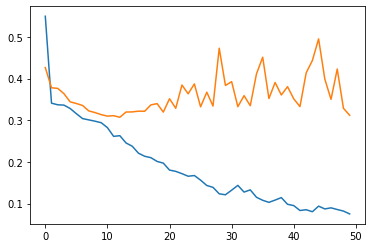

epoch min valid 12
tn= 213 fp= 2 fn= 16 tp= 12
0.7096345514950166
Epoch: 0 Training Loss:  0.46931176730271046 Validation Loss:  0.3607389032840729
Epoch: 10 Training Loss:  0.2530593913883485 Validation Loss:  0.29634881019592285
Epoch: 20 Training Loss:  0.1640921082403832 Validation Loss:  0.3146657943725586
Epoch: 30 Training Loss:  0.10757791529234463 Validation Loss:  0.3387008607387543
Epoch: 40 Training Loss:  0.09740734427177813 Validation Loss:  0.28132736682891846


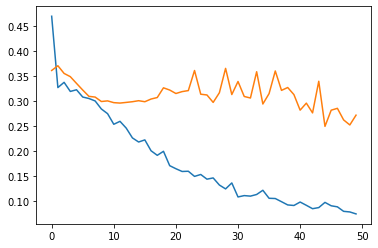

epoch min valid 44
tn= 213 fp= 2 fn= 13 tp= 15
0.7632059800664452


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5127753441703731 Validation Loss:  0.3802849054336548
Epoch: 10 Training Loss:  0.2469756150762711 Validation Loss:  0.3910796344280243
Epoch: 20 Training Loss:  0.19351944972215027 Validation Loss:  0.40995723009109497
Epoch: 30 Training Loss:  0.1303672288482254 Validation Loss:  0.45993563532829285
Epoch: 40 Training Loss:  0.09229699013004737 Validation Loss:  0.3881895840167999


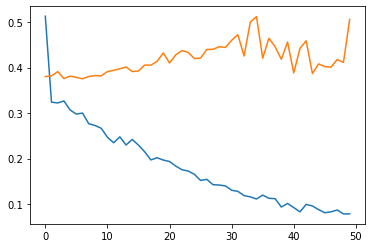

epoch min valid 6
tn= 214 fp= 0 fn= 20 tp= 8
0.6428571428571428


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5115386472693805 Validation Loss:  0.40908995270729065
Epoch: 10 Training Loss:  0.27124407619623275 Validation Loss:  0.32063010334968567
Epoch: 20 Training Loss:  0.18369981755887896 Validation Loss:  0.3681829869747162
Epoch: 30 Training Loss:  0.12225205647221722 Validation Loss:  0.46192899346351624
Epoch: 40 Training Loss:  0.1052480072012768 Validation Loss:  0.48365986347198486


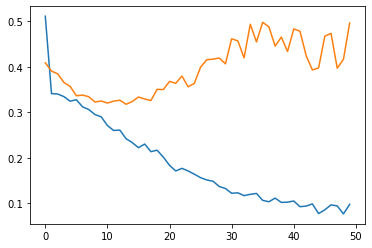

epoch min valid 13
tn= 214 fp= 1 fn= 18 tp= 10
0.6762458471760797
Epoch: 0 Training Loss:  0.5292151932058663 Validation Loss:  0.41885700821876526
Epoch: 10 Training Loss:  0.2718251554552337 Validation Loss:  0.38432076573371887
Epoch: 20 Training Loss:  0.18784913138309814 Validation Loss:  0.3654978573322296
Epoch: 30 Training Loss:  0.12029437777939542 Validation Loss:  0.3878155052661896
Epoch: 40 Training Loss:  0.09060083955921762 Validation Loss:  0.37639564275741577


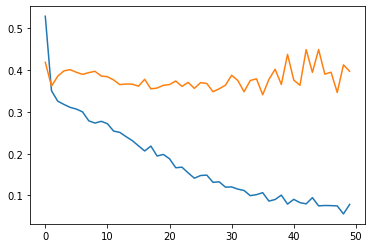

epoch min valid 35
tn= 215 fp= 0 fn= 19 tp= 9
0.6607142857142857
Epoch: 0 Training Loss:  0.552088989471567 Validation Loss:  0.4633266031742096
Epoch: 10 Training Loss:  0.2809182175146095 Validation Loss:  0.2943250238895416
Epoch: 20 Training Loss:  0.20362017110375494 Validation Loss:  0.2951734960079193
Epoch: 30 Training Loss:  0.14399158603748596 Validation Loss:  0.27739202976226807
Epoch: 40 Training Loss:  0.11733535139892724 Validation Loss:  0.26787498593330383


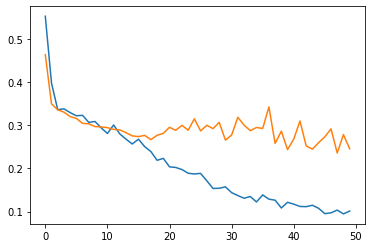

epoch min valid 47
tn= 215 fp= 0 fn= 19 tp= 9
0.6607142857142857


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5037605123273258 Validation Loss:  0.3872213661670685
Epoch: 10 Training Loss:  0.2690822206694504 Validation Loss:  0.3486683666706085
Epoch: 20 Training Loss:  0.18018621100626628 Validation Loss:  0.40888169407844543
Epoch: 30 Training Loss:  0.12346431610188527 Validation Loss:  0.48167547583580017
Epoch: 40 Training Loss:  0.09574649422248857 Validation Loss:  0.5144219994544983


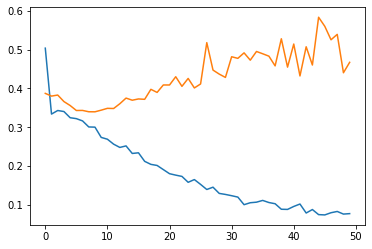

epoch min valid 8
tn= 214 fp= 0 fn= 18 tp= 10
0.6785714285714286


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5275041237987321 Validation Loss:  0.3988827168941498
Epoch: 10 Training Loss:  0.28069747838930326 Validation Loss:  0.3476841449737549
Epoch: 20 Training Loss:  0.18759094732652964 Validation Loss:  0.35108429193496704
Epoch: 30 Training Loss:  0.13053630708861325 Validation Loss:  0.33473557233810425
Epoch: 40 Training Loss:  0.10602050941780708 Validation Loss:  0.3360668420791626


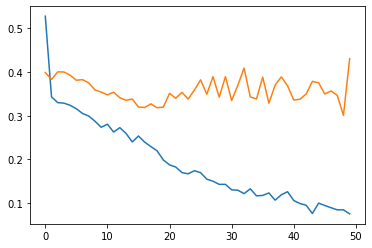

epoch min valid 48
tn= 215 fp= 0 fn= 23 tp= 5
0.5892857142857143
Epoch: 0 Training Loss:  0.506496904225185 Validation Loss:  0.39229145646095276
Epoch: 10 Training Loss:  0.2493810686411272 Validation Loss:  0.36113908886909485
Epoch: 20 Training Loss:  0.1753092258056658 Validation Loss:  0.41842031478881836
Epoch: 30 Training Loss:  0.11884498878864869 Validation Loss:  0.5763168931007385
Epoch: 40 Training Loss:  0.08121103926203996 Validation Loss:  0.6124152541160583


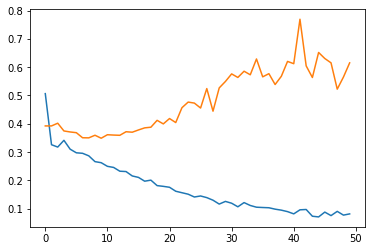

epoch min valid 9
tn= 215 fp= 0 fn= 22 tp= 6
0.6071428571428571
Epoch: 0 Training Loss:  0.5337737572604212 Validation Loss:  0.42740580439567566
Epoch: 10 Training Loss:  0.27238088731557647 Validation Loss:  0.3019901514053345
Epoch: 20 Training Loss:  0.21271149171436013 Validation Loss:  0.3026253283023834
Epoch: 30 Training Loss:  0.14810938367716453 Validation Loss:  0.29810065031051636
Epoch: 40 Training Loss:  0.11604886325329312 Validation Loss:  0.27668464183807373


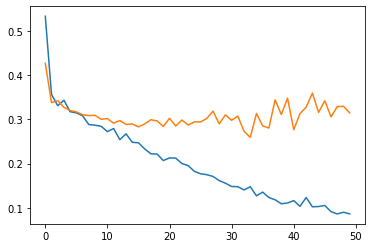

epoch min valid 33
tn= 215 fp= 0 fn= 21 tp= 7
0.625


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.4933139677705436 Validation Loss:  0.37870192527770996
Epoch: 10 Training Loss:  0.2677488375776287 Validation Loss:  0.3434879183769226
Epoch: 20 Training Loss:  0.18726848593013812 Validation Loss:  0.3692198693752289
Epoch: 30 Training Loss:  0.11099309740098322 Validation Loss:  0.4086059331893921
Epoch: 40 Training Loss:  0.0844931528195518 Validation Loss:  0.42085951566696167


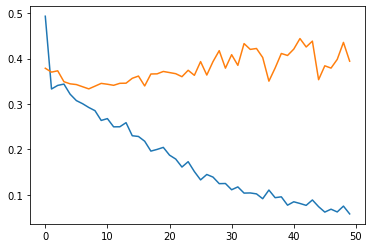

epoch min valid 7
tn= 214 fp= 0 fn= 12 tp= 16
0.7857142857142857


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5232363225057207 Validation Loss:  0.4143962264060974
Epoch: 10 Training Loss:  0.27396015932719253 Validation Loss:  0.3132625222206116
Epoch: 20 Training Loss:  0.1915820610155512 Validation Loss:  0.2982746362686157
Epoch: 30 Training Loss:  0.1354126133995782 Validation Loss:  0.32823267579078674
Epoch: 40 Training Loss:  0.09938903255977743 Validation Loss:  0.26036056876182556


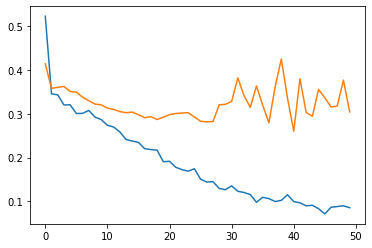

epoch min valid 40
tn= 215 fp= 0 fn= 17 tp= 11
0.6964285714285714
Epoch: 0 Training Loss:  0.5560299583550157 Validation Loss:  0.43942397832870483
Epoch: 10 Training Loss:  0.260536282464605 Validation Loss:  0.3731602728366852
Epoch: 20 Training Loss:  0.1870551953710423 Validation Loss:  0.41808202862739563
Epoch: 30 Training Loss:  0.12239307978462452 Validation Loss:  0.5150981545448303
Epoch: 40 Training Loss:  0.10011895353800983 Validation Loss:  0.5367241501808167


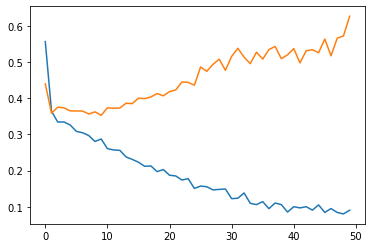

epoch min valid 9
tn= 215 fp= 0 fn= 21 tp= 7
0.625
Epoch: 0 Training Loss:  0.48602413792034677 Validation Loss:  0.3754618763923645
Epoch: 10 Training Loss:  0.2399976682656541 Validation Loss:  0.3621276915073395
Epoch: 20 Training Loss:  0.1706313115267629 Validation Loss:  0.42407065629959106
Epoch: 30 Training Loss:  0.1146193697959022 Validation Loss:  0.4803418219089508
Epoch: 40 Training Loss:  0.0936273283379329 Validation Loss:  0.42082679271698


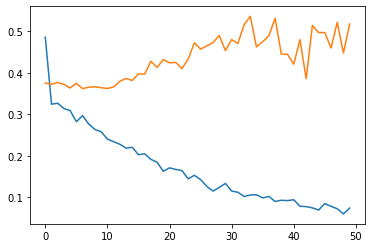

epoch min valid 6
tn= 214 fp= 1 fn= 16 tp= 12
0.7119601328903654


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5128264907105216 Validation Loss:  0.3885630965232849
Epoch: 10 Training Loss:  0.28138023185832745 Validation Loss:  0.29827606678009033
Epoch: 20 Training Loss:  0.18849356984378418 Validation Loss:  0.28928342461586
Epoch: 30 Training Loss:  0.13633851914333905 Validation Loss:  0.31658121943473816
Epoch: 40 Training Loss:  0.10702416356199874 Validation Loss:  0.31991809606552124


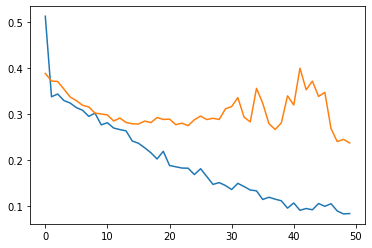

epoch min valid 49
tn= 212 fp= 2 fn= 13 tp= 15
0.7631842456608812


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([243])) that is different to the input size (torch.Size([243, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.49346939253396 Validation Loss:  0.3766515851020813
Epoch: 10 Training Loss:  0.2545003063719848 Validation Loss:  0.302829384803772
Epoch: 20 Training Loss:  0.18308373317082316 Validation Loss:  0.3076828718185425
Epoch: 30 Training Loss:  0.12548535341381373 Validation Loss:  0.3462238907814026
Epoch: 40 Training Loss:  0.08650923879176844 Validation Loss:  0.36518746614456177


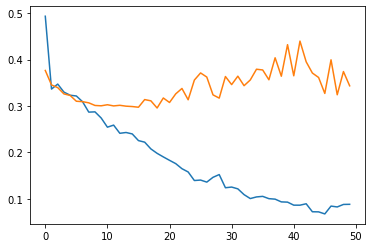

epoch min valid 18
tn= 214 fp= 1 fn= 17 tp= 11
0.6941029900332226
Epoch: 0 Training Loss:  0.5530953080489718 Validation Loss:  0.4262060821056366
Epoch: 10 Training Loss:  0.26189244468696415 Validation Loss:  0.3978915512561798
Epoch: 20 Training Loss:  0.18596627089548215 Validation Loss:  0.42594239115715027
Epoch: 30 Training Loss:  0.12230159754589891 Validation Loss:  0.4543587267398834
Epoch: 40 Training Loss:  0.08140665560976827 Validation Loss:  0.49601057171821594


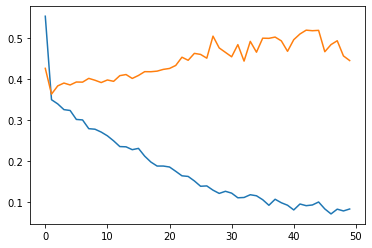

epoch min valid 1
tn= 215 fp= 0 fn= 16 tp= 12
0.7142857142857143
Epoch: 0 Training Loss:  0.5263619198881346 Validation Loss:  0.39303070306777954
Epoch: 10 Training Loss:  0.2653386466566409 Validation Loss:  0.31167489290237427
Epoch: 20 Training Loss:  0.18201110125639766 Validation Loss:  0.34537339210510254
Epoch: 30 Training Loss:  0.11898059246213961 Validation Loss:  0.41070491075515747
Epoch: 40 Training Loss:  0.0895237129816294 Validation Loss:  0.42214953899383545


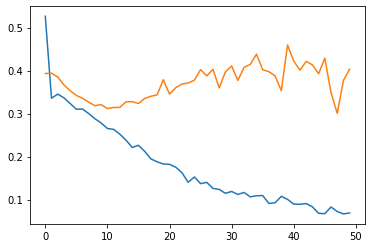

epoch min valid 47
tn= 214 fp= 1 fn= 17 tp= 11
0.6941029900332226


/home/jeroen/miniconda3/envs/GNN/lib/python3.8/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([242])) that is different to the input size (torch.Size([242, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0 Training Loss:  0.5192291270042287 Validation Loss:  0.4172862470149994
Epoch: 10 Training Loss:  0.27020908090574985 Validation Loss:  0.34067443013191223
Epoch: 20 Training Loss:  0.19625083605662502 Validation Loss:  0.32331857085227966
Epoch: 30 Training Loss:  0.14504078539005072 Validation Loss:  0.29998579621315
Epoch: 40 Training Loss:  0.10755578552050103 Validation Loss:  0.3269581198692322


KeyboardInterrupt: 

In [30]:
for i in range(40):
    skf = StratifiedKFold(n_splits=4, random_state=i, shuffle=True)
    X = dat[2].values
    y = dat[1].values
    X = [[int(number) for number in group] for group in X]
    skf.get_n_splits(X, y)
    X = np.array(X)
    bac=[]
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = torch.from_numpy(np.array(X_train)).type(torch.Tensor)
        y_train = torch.from_numpy(np.array(y_train)).type(torch.Tensor)

        X_test = torch.from_numpy(np.array(X_test)).type(torch.Tensor)
        y_test = torch.from_numpy(np.array(y_test)).type(torch.Tensor)

        trained_model = trainer(inp, hid1, hid2, hid3, learning_rate, X_train, y_train, X_test, y_test, 50, 5)
        score_model(X_test, trained_model, y_test)

In [ ]:
skf = StratifiedKFold(n_splits=5, random_state=79, shuffle=True)

vals_neg = []
vals_pos = []

outputs = []
accuracies = []
idx = 0
eps = [100, 100, 100, 100, 100]
for train_idx, test_idx in skf.split(dataset.values, dataset[[label_str]].values):
    
    X_train = torch.from_numpy(np.array(dataset.values[train_idx,:-1])).type(torch.Tensor)
    y_train = torch.from_numpy(np.array(dataset.values[train_idx, -1])).type(torch.Tensor)

    X_test = torch.from_numpy(np.array(dataset.values[test_idx,:-1])).type(torch.Tensor)
    y_test = torch.from_numpy(np.array(dataset.values[test_idx,-1])).type(torch.Tensor)
    
    
    trained_model = trainer2(inp, hid1, hid2, hid3, learning_rate, X_train, y_train, eps[idx], 5)
    accuracies.append(score_model(X_test, trained_model, y_test))
    idx+=1
    
    trained_model.eval()
    output = trained_model(X_test)
    output = [1 if x[0] >= 0.50 else 0 for x in output.tolist()]
    print('vals positief')
    for i in range(len(output)):
        if output[i] == 1 and y_test[i] != 1:
            vals_pos.append(smiles_maccs.values[test_idx][i])
    print('vals negatief')
    for i in range(len(output)):
        if output[i] != 1 and y_test[i] == 1:
            vals_neg.append(smiles_maccs.values[test_idx][i])

print(np.mean([x[0] for x in accuracies]))
print(np.mean([x[1] for x in accuracies]))